In [1]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.multivariate import pca

# prepare the data

In [2]:
lights = pd.read_csv(
    "data/lights_ua.csv",
    encoding='utf-8', sep = ",", quotechar = "\"", decimal = "."
).drop(['Unnamed: 0', 'area_name', 'iso3c'], axis=1)
lights.head()

,area_km2,year,NAME_1,mean_obs,sum,min,mean,max
0,20942.668075,2004,Cherkasy,48.176982,62557,0,1.679022,51
1,32463.303967,2004,Chernihiv,49.998010,43315,0,0.718468,44
2,8208.455146,2004,Chernivtsi,47.110010,44298,0,3.090199,53
3,26325.882157,2004,Crimea,47.934768,75817,0,1.742679,57
4,31772.459799,2004,Dnipropetrovs'k,49.158885,225588,0,4.069782,63


In [3]:
grp = pd.read_csv("data/grp_ua.csv")
grp.head()

,region_eng,region_ua,grp_2004,grp_2005,grp_2006
0,Ukraine,Україна,345113,441452,544153
1,Crimea,Автономна\n Республіка Крим,9901,12848,16044
2,Vinnytsya,Вінницька,8123,10207,12414
3,Volyn,Волинська,4994,6553,7687
4,Dnipropetrovs'k,Дніпропетровська,30040,41227,52347


In [4]:
income = pd.read_csv("data/income_ua.csv")
income.head()

,region_eng,region_ua,income_2004,income_2005,income_2006,disposable_income_2004,disposable_income_2005,disposable_income_2006,spendings_2004,spendings_2005,spendings_2006
0,Ukraine,Україна,274241,381404,472061,212033,298275,363586,242607,335753,427858
1,Crimea,Автономна Республіка Крим,10022,13883,16834,7676,10806,13006,9834,13521,17270
2,Vinnytsya,Вінницька,8747,12193,14788,7016,9908,11825,6605,9306,12040
3,Volyn,Волинська,4941,6808,8414,3904,5478,6638,4409,6070,7796
4,Dnipropetrovs'k,Дніпропетровська,22241,31344,38694,17124,24287,29652,19578,26711,32594


In [5]:
economy_stats = pd.merge(left=income,right=grp,on=['region_ua', 'region_eng'])
economy_stats.head()

,region_eng,region_ua,income_2004,income_2005,income_2006,disposable_income_2004,disposable_income_2005,disposable_income_2006,spendings_2004,spendings_2005,spendings_2006,grp_2004,grp_2005,grp_2006
0,Ukraine,Україна,274241,381404,472061,212033,298275,363586,242607,335753,427858,345113,441452,544153
1,Vinnytsya,Вінницька,8747,12193,14788,7016,9908,11825,6605,9306,12040,8123,10207,12414
2,Volyn,Волинська,4941,6808,8414,3904,5478,6638,4409,6070,7796,4994,6553,7687
3,Dnipropetrovs'k,Дніпропетровська,22241,31344,38694,17124,24287,29652,19578,26711,32594,30040,41227,52347
4,Donets'k,Донецька,29497,40753,50947,23407,32945,40752,20764,28840,38826,45617,58044,72361


In [6]:
def unpivot_category(
        data_frame: pd.DataFrame,
        category_name: str,
        index_column: str,
        years: List[int] = (2004,2005,2006)
) -> pd.DataFrame:
    categories_list = [f"{category_name}_{year}" for year in years]
    melted = data_frame[[index_column, *categories_list]].melt(
        id_vars=index_column,
        value_vars=categories_list,
        var_name='variable',
        value_name=category_name,
        ignore_index=False
    )
    melted[['year']] = melted['variable'].str.extract(r'(\d{4})')
    melted.drop(labels=['variable'], axis=1, inplace=True)

    return melted

In [7]:
unpivoted_dfs = [
    unpivot_category(economy_stats, category, 'region_eng')
    for category in ('income', 'disposable_income', 'spendings', 'grp')
]
economy_data = pd.concat(unpivoted_dfs, ignore_index=True).groupby(['region_eng', 'year'], as_index=False).sum()
economy_data.head()

,region_eng,year,income,disposable_income,spendings,grp
0,Cherkasy,2004,6744.0,5300.0,5396.0,6623.0
1,Cherkasy,2005,9392.0,7467.0,7541.0,9014.0
2,Cherkasy,2006,11589.0,9070.0,10013.0,10957.0
3,Chernihiv,2004,6303.0,5063.0,4748.0,6181.0
4,Chernihiv,2005,8650.0,7044.0,6379.0,7627.0


In [8]:
lights['region_eng'] = lights['NAME_1'].astype(str)
lights.drop('NAME_1', axis=1, inplace=True)

In [9]:
economy_data['region_eng'] = economy_data['region_eng'].astype(str)
economy_data['year'] = economy_data['year'].astype(int)

In [10]:
full_data = pd.merge(left=economy_data,right=lights, on=['region_eng', 'year'])
full_data.head()

,region_eng,year,income,disposable_income,spendings,grp,area_km2,mean_obs,sum,min,mean,max
0,Cherkasy,2004,6744.0,5300.0,5396.0,6623.0,20942.668075,48.176982,62557,0,1.679022,51
1,Cherkasy,2005,9392.0,7467.0,7541.0,9014.0,20942.668075,61.668367,94052,0,2.524344,56
2,Cherkasy,2006,11589.0,9070.0,10013.0,10957.0,20942.668075,49.161334,75655,0,2.030571,51
3,Chernihiv,2004,6303.0,5063.0,4748.0,6181.0,32463.303967,49.998010,43315,0,0.718468,44
4,Chernihiv,2005,8650.0,7044.0,6379.0,7627.0,32463.303967,54.603420,64898,0,1.076466,56


In [11]:
data_points = full_data[[
    'income',
    'disposable_income',
    'spendings',
    'grp',
    'mean',
    'sum',
    'max'
]]
data_points

,income,disposable_income,spendings,grp,mean,sum,max
0,6744.0,5300.0,5396.0,6623.0,1.679022,62557,51
1,9392.0,7467.0,7541.0,9014.0,2.524344,94052,56
2,11589.0,9070.0,10013.0,10957.0,2.030571,75655,51
3,6303.0,5063.0,4748.0,6181.0,0.718468,43315,44
4,8650.0,7044.0,6379.0,7627.0,1.076466,64898,56
...,...,...,...,...,...,...,...
70,16360.0,13223.0,14602.0,19968.0,2.525456,115527,62
71,20148.0,16118.0,17246.0,24787.0,2.202230,100741,59
72,6867.0,5390.0,5188.0,5947.0,0.792523,43607,45
73,9418.0,7449.0,7149.0,7430.0,0.916108,50407,56


# data analysis

In [12]:
# corrplot
def corrplot(df):
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plot
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, mask=mask, annot=True, xticklabels=True, yticklabels=True)
    plt.show()

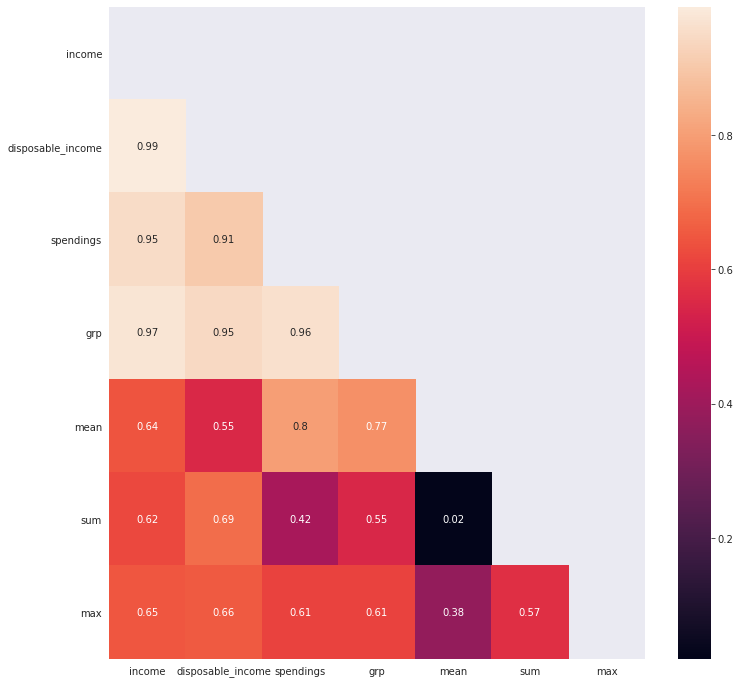

In [13]:
corrplot(data_points)

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


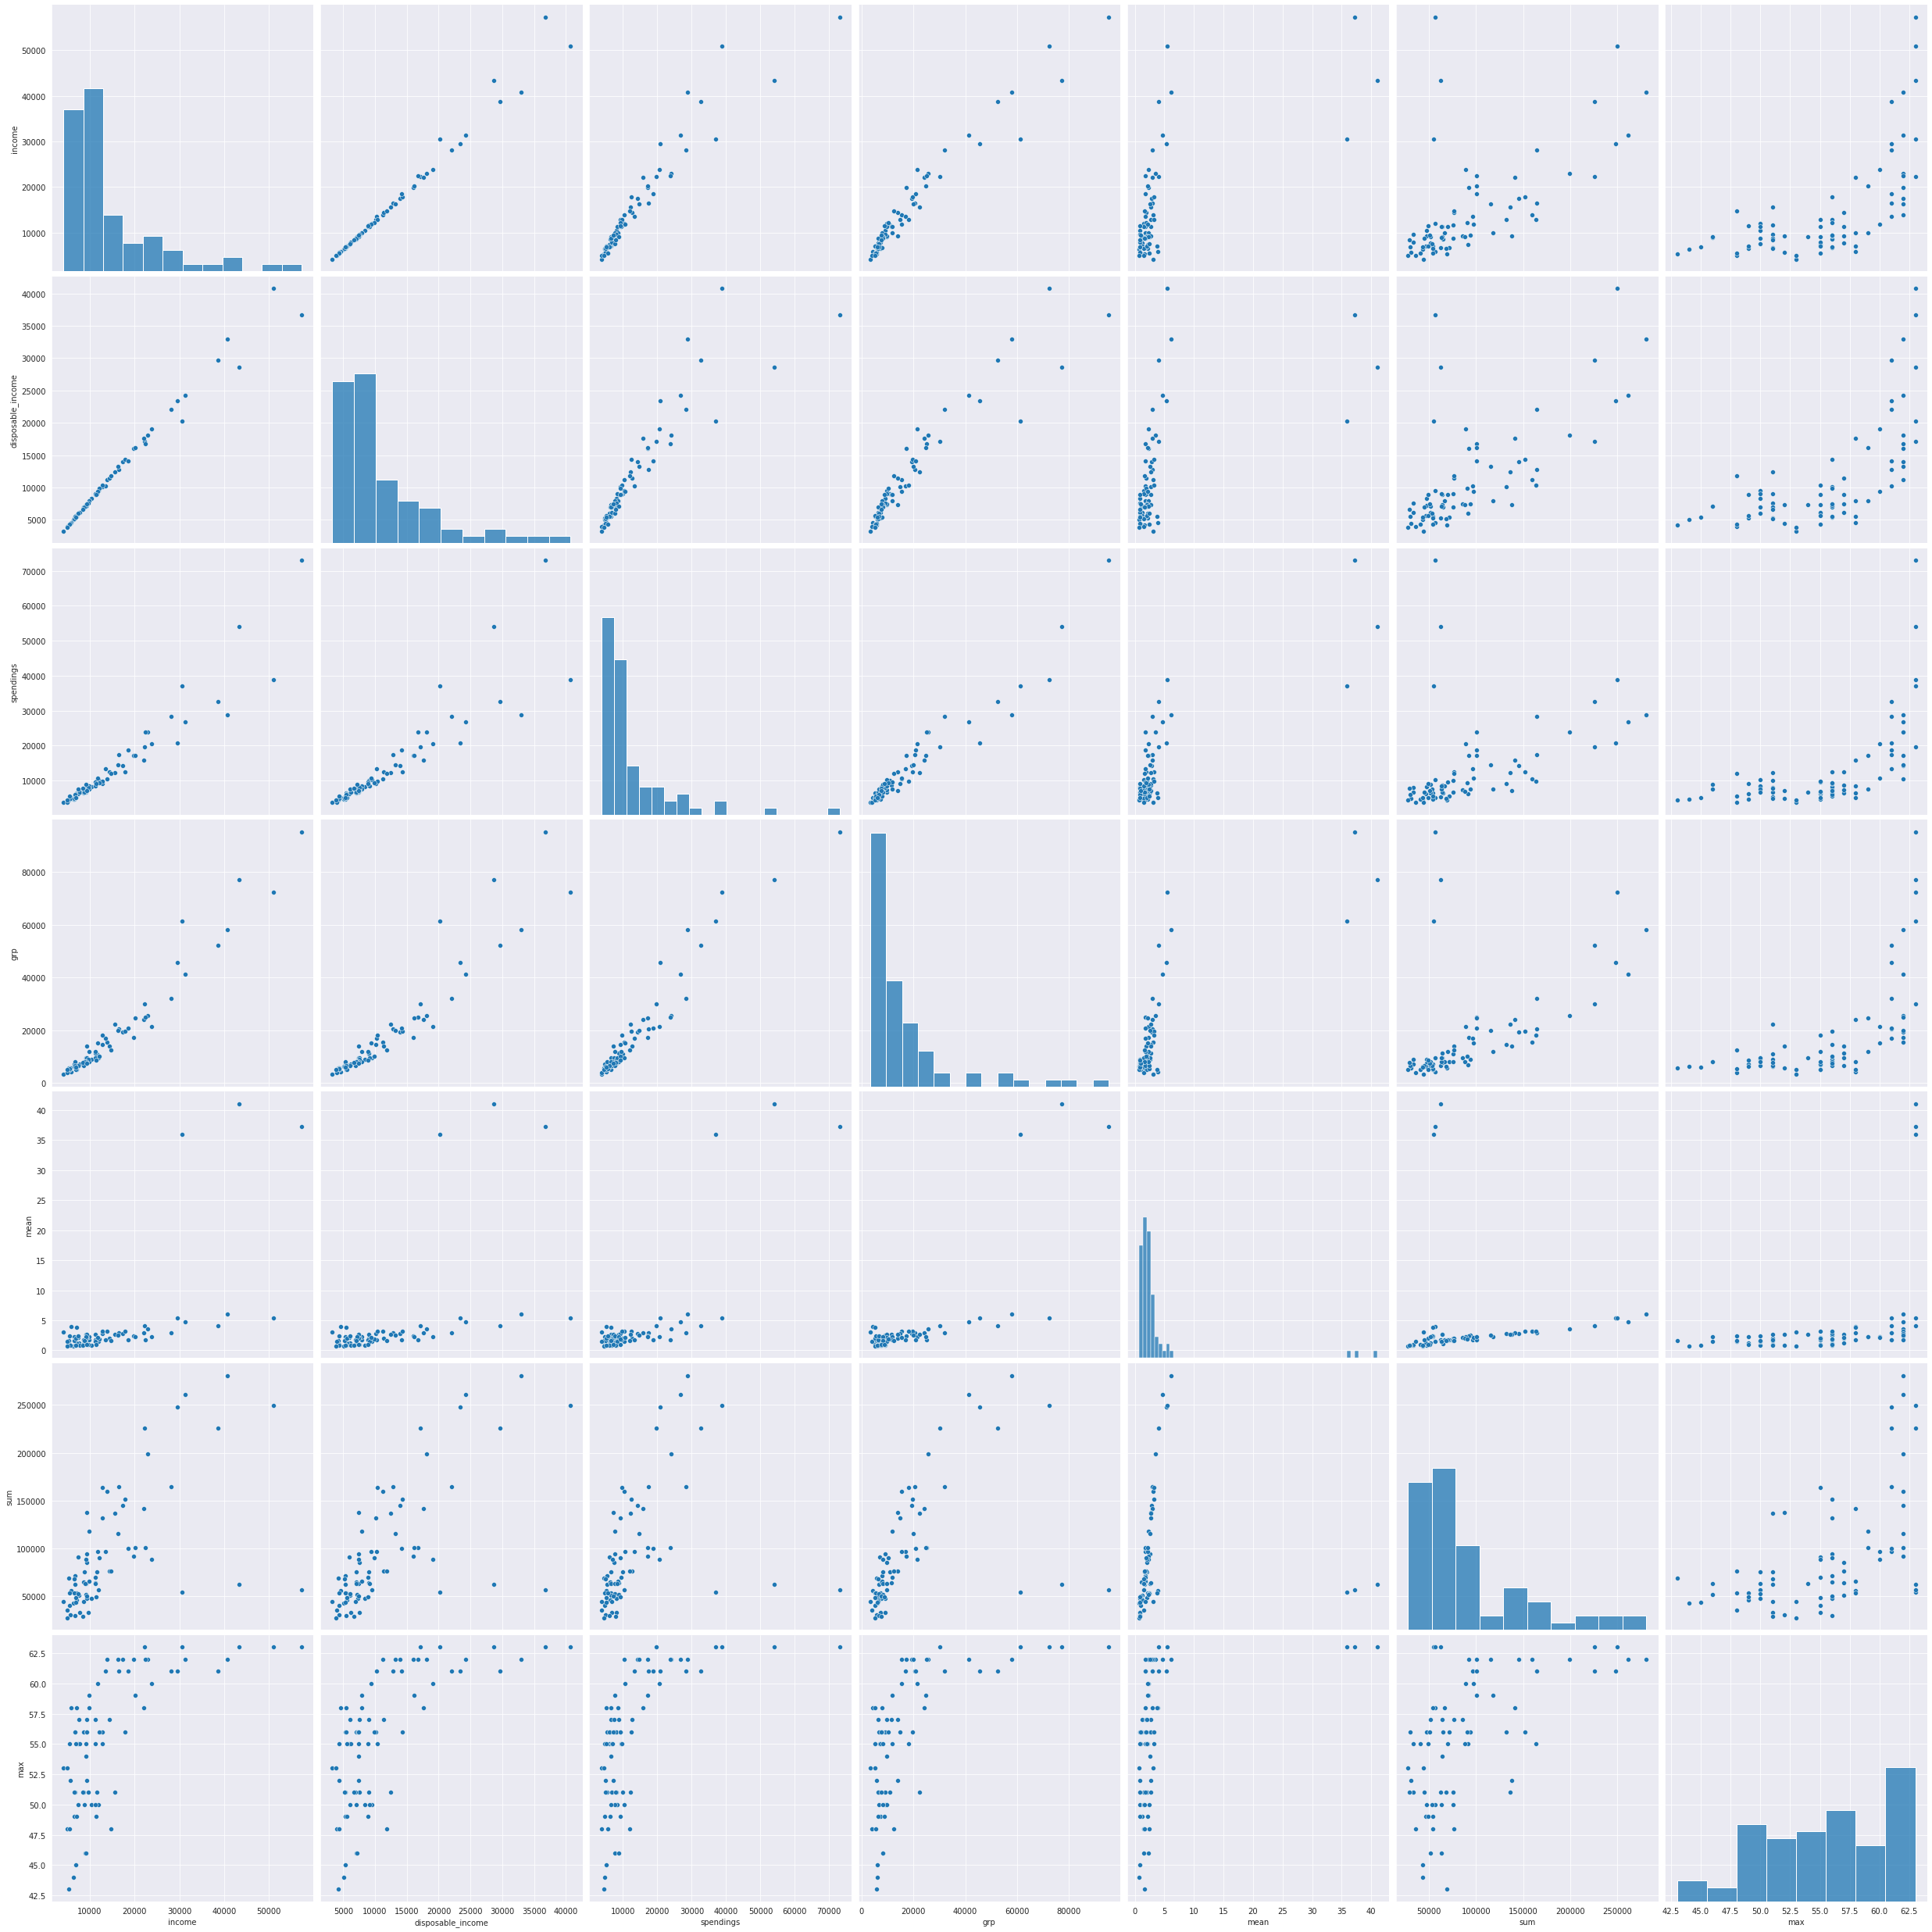

In [14]:
sns.pairplot(data_points, size=5)

# apply different models


first we normalize the data

In [15]:
scaler = MinMaxScaler()
data_points = pd.DataFrame(scaler.fit_transform(data_points), columns=data_points.columns)
data_points.head()

,income,disposable_income,spendings,grp,mean,sum,max
0,0.048888,0.053553,0.024662,0.036374,0.023813,0.137190,0.40
1,0.098698,0.111405,0.055597,0.062365,0.044769,0.261622,0.65
2,0.140025,0.154199,0.091249,0.083487,0.032528,0.188938,0.40
3,0.040593,0.047226,0.015316,0.031569,0.000000,0.061167,0.05
4,0.084741,0.100112,0.038839,0.047288,0.008875,0.146439,0.65


## linear regression

### single regressor models

In [38]:
y = data_points['mean']
x = data_points['income']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
xc = sm.add_constant(X_train)

# Fit the regression model
lr_model = sm.OLS(y_train, xc).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     49.04
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.71e-09
Time:                        23:30:33   Log-Likelihood:                 36.291
No. Observations:                  67   AIC:                            -68.58
Df Residuals:                      65   BIC:                            -64.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0393      0.024     -1.640      0.106      -0.087       0.009
income         0.5958      0.085      7.003      0.000       0.426       0.766
==============================================================================
Omnibus:                       51.415   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.973
Skew:                           2.117   Prob(JB):                     1.60e-61
Kurtosis:                      12.075   Cond. No.                         5.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
y = data_points['mean']
x = data_points['grp']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
xc = sm.add_constant(X_train)

# Fit the regression model
lr_model = sm.OLS(y_train, xc).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     104.6
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           3.63e-15
Time:                        23:30:34   Log-Likelihood:                 49.584
No. Observations:                  67   AIC:                            -95.17
Df Residuals:                      65   BIC:                            -90.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0353      0.018     -1.965      0.054      -0.071       0.001
grp            0.7382      0.072     10.227      0.000       0.594       0.882
==============================================================================
Omnibus:                       24.441   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.004
Skew:                           0.684   Prob(JB):                     2.93e-30
Kurtosis:                       9.844   Cond. No.                         5.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
y = data_points['mean']
x = data_points['spendings']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
xc = sm.add_constant(X_train)

# Fit the regression model
lr_model = sm.OLS(y_train, xc).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     119.3
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           2.36e-16
Time:                        23:30:34   Log-Likelihood:                 52.376
No. Observations:                  67   AIC:                            -100.8
Df Residuals:                      65   BIC:                            -96.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0402      0.017     -2.318      0.024      -0.075      -0.006
spendings      0.8694      0.080     10.924      0.000       0.710       1.028
==============================================================================
Omnibus:                       36.947   Durbin-Watson:                   2.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.810
Skew:                           1.421   Prob(JB):                     8.11e-38
Kurtosis:                      10.288   Cond. No.                         5.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
y = data_points['mean']
x = data_points['disposable_income']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
xc = sm.add_constant(X_train)

# Fit the regression model
lr_model = sm.OLS(y_train, xc).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     29.81
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           8.02e-07
Time:                        23:30:36   Log-Likelihood:                 30.104
No. Observations:                  67   AIC:                            -56.21
Df Residuals:                      65   BIC:                            -51.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0285      0.027     -1.054      0.296      -0.082       0.025
disposable_income     0.4974      0.091      5.460      0.000       0.315       0.679
==============================================================================
Omnibus:                       63.308   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.648
Skew:                           2.741   Prob(JB):                     3.68e-88
Kurtosis:                      13.686   Cond. No.                         4.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### multiple regressor models

In [ ]:
y = data_points['mean']
x = data_points[['grp', 'income', 'spendings']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [17]:
xc = sm.add_constant(X_train)

# Fit the regression model
lr_model = sm.OLS(y_train, xc).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     223.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           1.53e-33
Time:                        23:21:55   Log-Likelihood:                 99.743
No. Observations:                  67   AIC:                            -191.5
Df Residuals:                      63   BIC:                            -182.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0420      0.010      4.003      0.000       0.021       0.063
grp            1.7204      0.182      9.473      0.000       1.358       2.083
income        -2.0625      0.147    -13.987      0.000      -2.357      -1.768
spendings      1.2968      0.165      7.879      0.000       0.968       1.626
==============================================================================
Omnibus:                        4.331   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.660
Skew:                           0.563   Prob(JB):                        0.160
Kurtosis:                       3.207   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
metrics.r2_score(y_test, lr_model.predict(sm.add_constant(X_test)))

0.45647728004376553

## ridge regression

In [ ]:
y = data_points['mean']
x = data_points[['grp', 'income', 'spendings']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

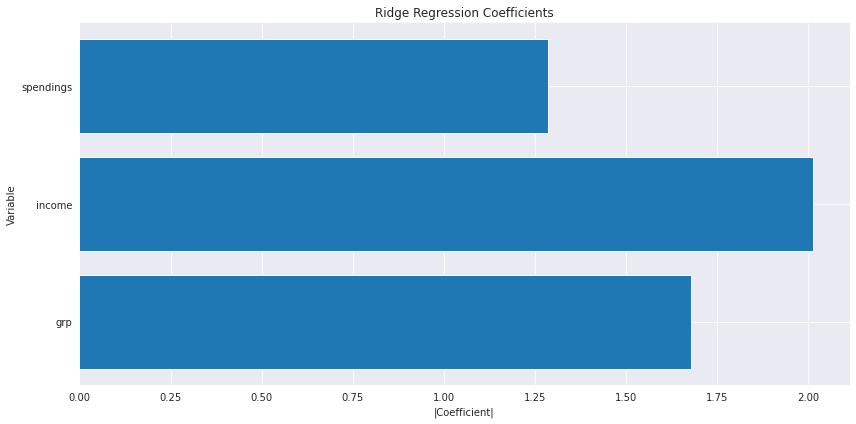

In [19]:
alpha = 2 * 10**(-3)  # You can choose different values for alpha
ridge = Ridge(alpha=alpha, fit_intercept=True)
ridge.fit(X_train, y_train)

# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns, np.abs(ridge.coef_))
plt.xlabel('|Coefficient|')
plt.ylabel('Variable')
plt.title('Ridge Regression Coefficients')
plt.tight_layout()
plt.show()

In [20]:
ridge.intercept_

0.0401852320110358

In [21]:
metrics.r2_score(y_train, ridge.predict(X_train))

0.9140850595161054

In [22]:
metrics.r2_score(y_test, ridge.predict(X_test))

0.45195573181283755

## PCA regression

In [23]:
y = data_points['mean']
x = data_points[['grp', 'income', 'disposable_income', 'spendings']]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [24]:
class PCA:
    def __init__(self, x):
        self.x = x
        self.pc = pca.PCA(x, method='eig')
        self.pc_fit = None
        self.lr_pca = None

    def get_eigenvalues(self):
        return self.pc.eigenvals

    def plot_eigenvalues(self):
        self.pc.plot_scree(log_scale=False)

    def transform_data(self, n_comp):
        self.pc_fit = pca.PCA(self.x, method='eig', ncomp=n_comp)

    def get_transformed_data(self):
        assert self.pc_fit
        return self.pc_fit.transformed_data

    def fit_regression(self, y):
        self.lr_pca = LinearRegression(fit_intercept=True).fit(self.x, y)

    def predict(self):
        assert self.lr_pca
        return self.lr_pca.predict(self.x)

In [25]:
def estim_ls(x,y):
    x1 = np.array(x)
    y1 = np.array(y)
    try:
        return np.linalg.inv(x1.T @ x1) @ x1.T @ y1
    except np.linalg.LinAlgError:
        return (1 / (x1.T @ x1)) * (x1.T @ y1)

In [26]:
pca_model = PCA(X_train)
pca_model.get_eigenvalues()

0    259.204184
1      6.981339
2      1.784387
3      0.030091
Name: eigenvals, dtype: float64

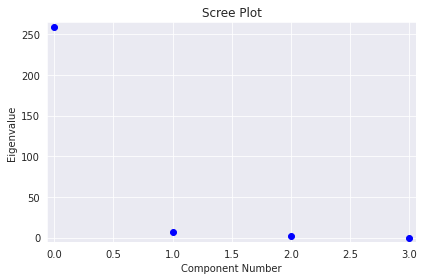

In [27]:
pca_model.plot_eigenvalues()

In [28]:
pca_model.transform_data(n_comp=2)
x_train_transformed = pca_model.get_transformed_data()
beta_pca = estim_ls(x_train_transformed, y_train)
metrics.r2_score(y_train, x_train_transformed @ beta_pca)

0.7580857317586434

In [29]:
pca_model.transform_data(n_comp=1)
x_train_transformed = pca_model.get_transformed_data()
beta_pca = estim_ls(x_train_transformed, y_train)
metrics.r2_score(y_train, x_train_transformed @ beta_pca)

0.7580857317586434

## XGBoost Regression

In [30]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
metrics.r2_score(y_train, xgb_model.predict(X_train))

0.9999573459326171

In [31]:
metrics.r2_score(y_test, xgb_model.predict(X_test))

0.6625628062572815